## Relationship between precipitation and river discharge seasonal forecasts

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import glob
import os
from weatherforce.standardization import standardize_coordinates
from pprint import pprint
from weatherforce.spacetime.space import bbox_from_data
from weatherforce.dataviz.maps.static import make_map_with_features
from calendar import monthrange

## C3S anomalies

In [2]:
def get_c3s_run_time(month:int = 1, downscaled:bool = True, hindcast:bool = False, forecast:bool = False) -> xr.Dataset:
    
    """
    Retrieve C3S ECMWF SEAS5 total precipitation data for a specific month.

    Parameters:
        month (int): Month value (1-12) for which to retrieve the data. Defaults to 1 (January).
        downscaled (bool): If True, retrieve the downscaled data. If False, retrieve the original forecast data.
                           Defaults to True.
        hindcast (bool): If True, filter the data to include only hindcast data within the range of 1993-01-01 to
                         2016-12-31. Applicable only when downscaled is True. Defaults to False.
        forecast (bool): If True, filter the data to include only forecast data starting from 2017-01-01.
                         Applicable only when downscaled is True. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing the C3S ECMWF SEAS5 total precipitation data for the specified month.

    """
    
    start_date = np.datetime64(dt.datetime(1993, 1, 1))
    end_date = np.datetime64(dt.datetime(2016, 12, 31))
    forecast_start = np.datetime64(dt.datetime(2017, 1, 1))
    
    if downscaled:
        ds = xr.open_mfdataset(f'/home/jovyan/data/share/Martin/ESA/WP11/c3s_seasonal/downscaled/tp/peru_north/1km/method_002/*/{month:02d}/*.nc', preprocess=preprocess)
        if hindcast:
            ds = ds.sel(run_time=(ds.run_time >= start_date) & (ds.run_time <= end_date))
        if forecast:
            ds = ds.sel(run_time=(ds.run_time >= forecast_start))
    else:
        ds = xr.open_mfdataset( f'/home/jovyan/data/forecast/c3s_seasonal/peru_north/*/*/{month:02d}/*.nc', preprocess=preprocess)

    with ProgressBar():
        ds = ds.load()
        
    return ds


In [3]:
def preprocess(ds,downscaled:bool = True) -> xr.Dataset:
    
    """
    Preprocess the C3S ECMWF SEAS5 total precipitation dataset.

    Parameters:
        ds (xr.Dataset): Dataset containing the C3S ECMWF SEAS5 total precipitation data.
        downscaled (bool): If True, the dataset represents downscaled data. If False, it represents original forecast data.
                           Defaults to True.

    Returns:
        xr.Dataset: Preprocessed dataset.

    """
    
    if 'tprate' in list(ds.keys()):

        nb_days = ds.time.dt.days_in_month
        # m/s to mm/month
        conversion_factor = 1e3 * 3600 * 24

        # Apply conversion
        converted_ds = ds * conversion_factor * nb_days
        converted_ds.attrs["units"] = "mm"
        # rename latitude and longitude to lat /lon (WF format)
        converted_ds = standardize_coordinates(converted_ds)

        # rename variable to tp
        ds = converted_ds.rename_vars(name_dict={'tprate': 'tp'})        
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        run_time = ds.indexes["time"][0]
        ds = ds.assign_coords({"run_time": run_time})
        ds = ds.expand_dims("run_time")
        ds = ds.assign_coords({"time": [i for i in range(1, 7)]})
        #ds = ds.assign_coords({"offset": ("time", [f"{i}MS" for i in range(6)])})
        ds = ds.rename({"time": "lead_time"})
        # put negative values to zeros
        ds['tp'] = xr.where(ds['tp'] < 0, 0, ds['tp'])

    return ds

In [4]:
def generate_c3s_anomalies(month: int = 1, year: int = 2018, type_an:str = 'absolute') -> xr.DataArray:
    """
    Generate total precipitation anomalies for a specific month and year.

    Parameters:
        month (int): Month for which to generate the anomalies (1-12).
        year (int): Year for which to generate the anomalies.
        type_an (str): Type of anomalies: 'absolute' or 'relative'.

    Returns:
        xr.DataArray: An array containing the total precipitation anomalies.

    """
    # Get the C3S ECMWF SEAS5 forecast dataset for the specified month
    if (year >= 2017):
        ds = get_c3s_run_time(month, downscaled=True, forecast=True)
    else:
        ds = get_c3s_run_time(month, downscaled=True, hindcast=True)

    # Select the forecast data for the specified year and month
    runtime = np.datetime64(dt.datetime(year, month, 1))
    ds_t = ds.sel(run_time=(ds.run_time == runtime))

    # Open the reference dataset for the corresponding month
    ref = xr.open_dataset(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/c3s_ref/tp_c3s_hindcast_month_{month}.nc')

    if (type_an=='absolute'):
        # Calculate the absolute anomalies by subtracting the forecast data from the reference data
        anomalies = ds_t.tp - ref.tp
        # Set the attributes for the anomalies dataset
        anomalies.attrs['units'] = 'mm'
        anomalies.attrs['long_name'] = 'Total precipitation absolute anomaly'
    elif (type_an=='relative'):
        # Calculate the relative anomalies
        anomalies = ((ds_t.tp - ref.tp)/ref.tp)*100
        anomalies.attrs['units'] = '%'
        anomalies.attrs['long_name'] = 'Total precipitation relative anomaly'
    else:
        print("Please choose the type of anomaly: 'absolute' or 'relative'.")
        anomalies = None

    return anomalies


In [5]:
def plot_tp_rel_anom_dam(year: int = 2021, month: int = 6):
    """
    Plots the relative precipitation anomaly for a specific month and year at the dam location.

    Args:
        year (int, optional): The year for which to plot the anomaly. Defaults to 2021.
        month (int, optional): The month for which to plot the anomaly. Defaults to 6.

    Returns:
        None
    """
    # Generate relative anomalies for the specified month and year
    anom = generate_c3s_anomalies(month=month, year=year, type_an='relative')
    
    # Location of the dam
    lat_dam, lon_dam = -7.230, -79.172
    
    # Select anomalies at the dam's location
    dam_anom = anom.sel(lat=lat_dam, lon=lon_dam, method='nearest')
    
    # Create a new figure and subplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    days_list = []
    time = [(month + val) % 12 or 12 for val in range(6)]
    tot = 0
    for month_k in time :
        if (month_k + 1) > 12:
            year = year + 1
        tot = tot + monthrange(year, month_k)[1]
        days_list.append(tot)

    # Plot the relative anomalies with circular markers
    plt.plot(days_list, dam_anom[0], marker='o')
    
    # Set labels and title
    plt.ylabel('Relative anomaly (%)')
    plt.xlabel('Step (month)')
    plt.title(f'Precipitation anomaly C3S model for {year}-{month:02d}')
    
    plt.show()

[########################################] | 100% Completed | 1.72 sms


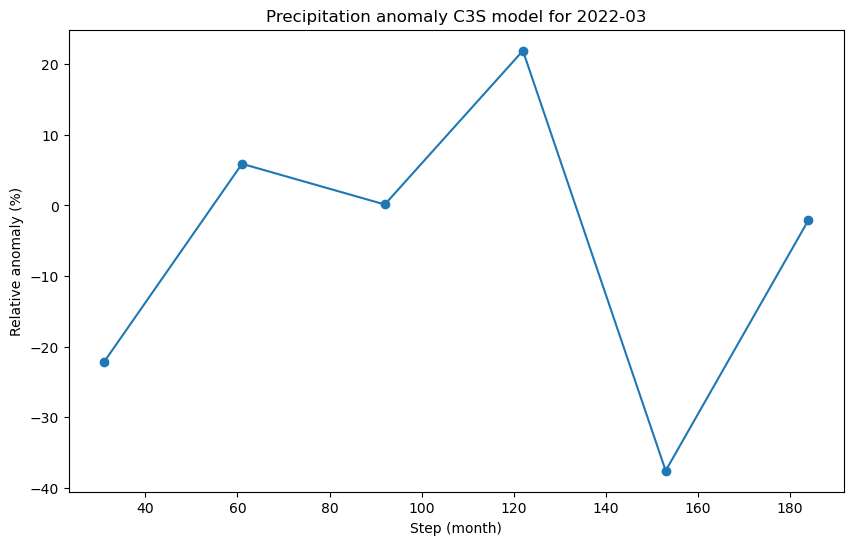

In [6]:
plot_tp_rel_anom_dam(2022,3)

## Glofas anomalies

In [6]:
def plot_q_runtime_anomalies_step(selected_year: int = 2021, selected_month: int = 6):
    """
    Plot the river discharge relative anomalies over different forecast steps for a specific month and year.

    Parameters:
        selected_year (int): The year for which anomalies are to be plotted (default: 2021).
        selected_month (int): The month for which anomalies are to be plotted (default: 6).

    Returns:
        None
    """
    # Read the dataset containing river discharge relative anomalies
    df_dam = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/glofas/dam_data.csv')
    
    # Filter the data for the specified month and year
    df_selected_month = df_dam[(df_dam['year'] == selected_year) & (df_dam['month'] == selected_month)]

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the relative anomalies against the forecast steps
    ax.plot(df_selected_month['step'], df_selected_month['anomaly_rel'], marker='o')
    
    # Set labels and title
    ax.set_xlabel('Step (days)')
    ax.set_ylabel('Relative anomaly (%)')
    ax.set_title(f'River discharge relative anomaly for Month {selected_month} in the year {selected_year}', fontsize=16)
    
    plt.show()

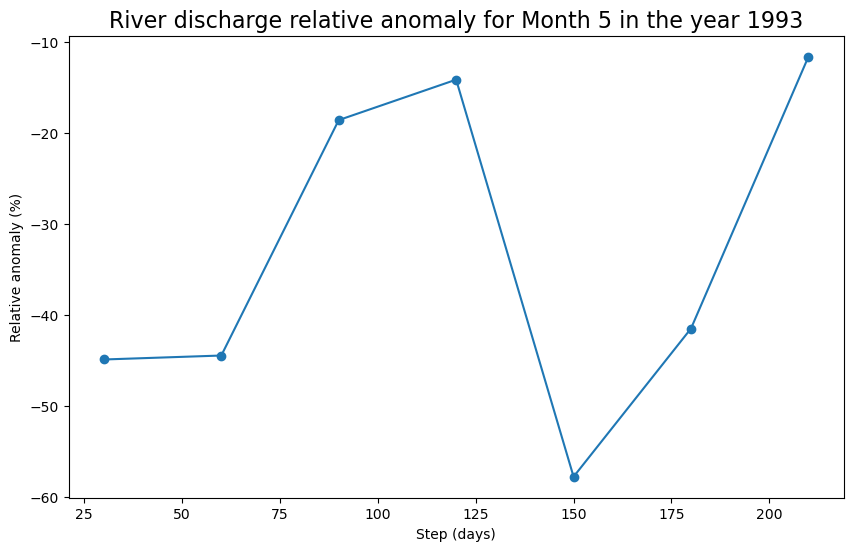

In [10]:
plot_q_runtime_anomalies_step(1993,5)

## C3S and GloFAS on the same plot

In [7]:
def plot_tp_c3s_q_glofas(year: int = 2021, month: int = 6):
    """
    Plots the relative precipitation anomaly for a specific month and year at the dam location.

    Args:
        year (int, optional): The year for which to plot the anomaly. Defaults to 2021.
        month (int, optional): The month for which to plot the anomaly. Defaults to 6.

    Returns:
        None
    """
    # Generate relative anomalies for the specified month and year
    anom = generate_c3s_anomalies(month=month, year=year, type_an='relative')
    
    # Location of the dam
    lat_dam, lon_dam = -7.230, -79.172
    
    # Select anomalies at the dam's location
    dam_anom = anom.sel(lat=lat_dam, lon=lon_dam, method='nearest')
    
    # Create a new figure and subplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    days_list = []
    time = [(month + val) % 12 or 12 for val in range(6)]
    tot = 0
    year_k = year
    for month_k in time :
        if (month_k + 1) > 12:
            year_k = year + 1
        tot = tot + monthrange(year_k, month_k)[1]
        days_list.append(tot)

    # Plot the relative anomalies with circular markers
    ax.plot(days_list, dam_anom[0], marker='o', label='c3s precipitation model')
    
    # Read the dataset containing river discharge relative anomalies
    df_dam = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/glofas/dam_data.csv')
    
    # Filter the data for the specified month and year
    df_selected_month = df_dam[(df_dam['year'] == year) & (df_dam['month'] == month)]
    
    # Plot the relative anomalies against the forecast steps
    ax.plot(df_selected_month['step'][:-1], df_selected_month['anomaly_rel'][:-1], marker='o', label='glofas river discharge model')
    
    # Set labels and title
    ax.set_xlabel('Step (days)')
    ax.set_ylabel('Relative anomaly (%)')
    ax.set_title(f'Relative anomalies for the leads from runtime {month}-{year}, at dam location', fontsize=16)
    
    plt.legend()
    
    plt.show()
    fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/relationship_tp_q/dam_rel_anomalies_{month}_{year}.png')
    plt.close()

[########################################] | 100% Completed | 922.93 ms


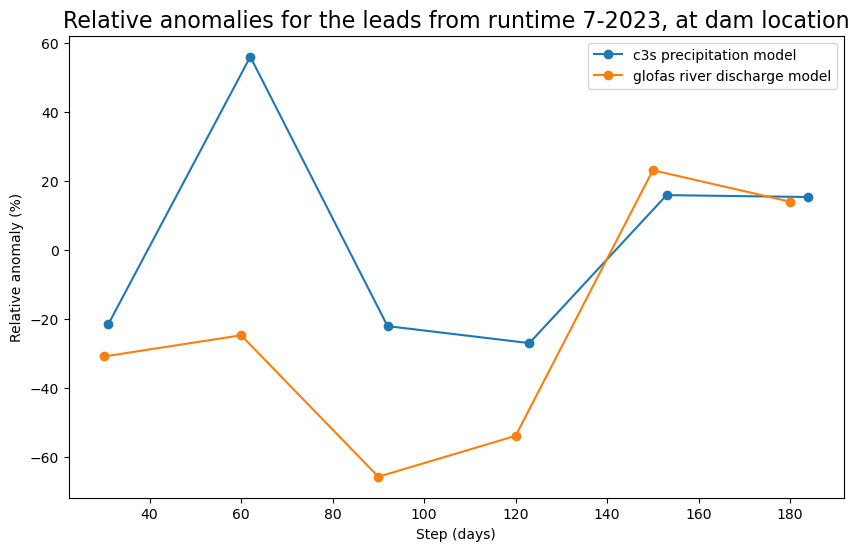

In [8]:
plot_tp_c3s_q_glofas(2023,7)

In [ ]:
for year in range (1993,2023):
    for month in range (1,13):
        plot_tp_c3s_q_glofas(year,month)
